In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf

import sys
sys.path.append('..')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import metrics

import warnings
warnings.filterwarnings('once')

In [2]:
hundred_models = 'inp_18__out_12__loss_mae__bksize_200__bkact_relu__dir_bi__'

p = Path('../results').absolute()

hundred_model_dirs = [str(p / hundred_models) + str(i) + '/best_weights.h5' for i in range(100)]

In [3]:
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

In [4]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [5]:
np.seterr(all='ignore')

def get_last_N(series, N=18):
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [6]:
X_test = np.array([get_last_N(ser[1], N=18) for ser in train.iterrows()])
y_test = test.values

In [7]:
def get_predictions(model, data):
        
    x = data[..., np.newaxis]
    
    mn, mx = x.min(axis=1), x.max(axis=1)
    x_sc = (x[..., 0] - mn) / (mx - mn)

    pred = model(x_sc[..., np.newaxis])

    return pred[..., 0] * (mx - mn) + mn

In [8]:
def ensemble_preds(model_family, data):

    preds = []
    
    for model_dir in tqdm(model_family):

        mape = metrics.build_mape(overlap=6)
        smape = metrics.build_smape(overlap=6)
        mase_estimate = metrics.build_mase(overlap=6)
        owa_estimate = metrics.build_owa(overlap=6)
        reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

        model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                      'MASE_estimate': mase_estimate,
                                                                      'OWA_estimate': owa_estimate,
                                                                      'reconstruction_loss': reconstruction_loss})
        preds.append(get_predictions(model, data))

        tf.keras.backend.clear_session()

    return np.stack(preds)

In [9]:
def evaluate_ensemble(preds, y_test):
    ensemble_preds = np.median(preds, axis=0)[:, 6:]
    return np.nanmean(metrics.SMAPE(y_test, ensemble_preds))

In [28]:
preds = ensemble_preds(hundred_model_dirs, X_test)

100%|██████████| 100/100 [07:45<00:00,  4.65s/it]


In [29]:
evaluate_ensemble(preds, y_test)

13.104683678898107

In [31]:
preds.shape

(100, 23000, 12)

In [33]:
smapes = []

for i in range(1, 101):
    smapes.append(evaluate_ensemble(preds[:i], y_test))

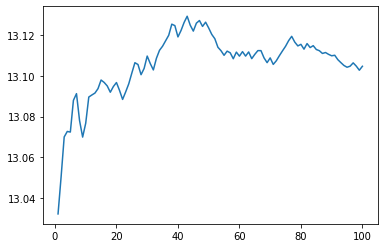

In [35]:
plt.plot(range(1, 101), smapes)

In [39]:
smapes = []

indices = np.random.permutation(100)

for i in range(1, 101):
    smapes.append(evaluate_ensemble(preds[indices[:i]], y_test))

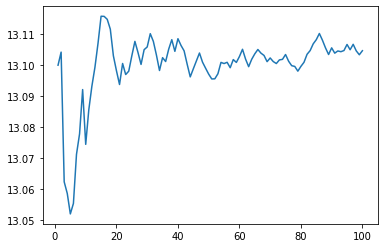

In [40]:
plt.plot(range(1, 101), smapes)

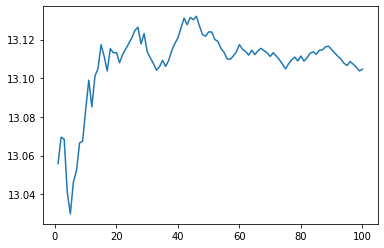

In [42]:
smapes = []

indices = np.random.permutation(100)

for i in range(1, 101):
    smapes.append(evaluate_ensemble(preds[indices[:i]], y_test))
    
plt.plot(range(1, 101), smapes)

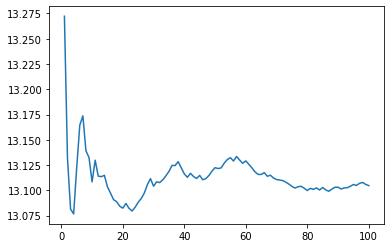

In [43]:
smapes = []

indices = np.random.permutation(100)

for i in range(1, 101):
    smapes.append(evaluate_ensemble(preds[indices[:i]], y_test))
    
plt.plot(range(1, 101), smapes)

In [25]:
def run(preds):
    
    smapes = []
    indices = np.random.permutation(100)

    for i in range(1, 101):
        smapes.append(evaluate_ensemble(preds[indices[:i]], y_test))
    
    return np.array(smapes)


# results = [run(preds) for _ in range(100)]

In [77]:
data = pd.DataFrame({'smape': pd.concat([pd.Series(r) for r in results])})

run = [[i] * 100 for i in range(100)]
data['num_ensembles'] = data.index
data['run'] = [item for sublist in run for item in sublist]

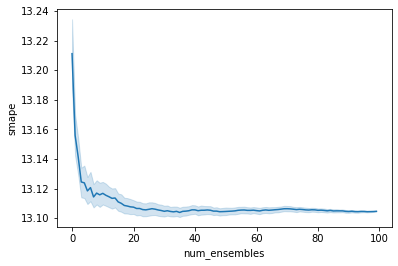

In [78]:
sns.lineplot(x='num_ensembles', y='smape', data=data)

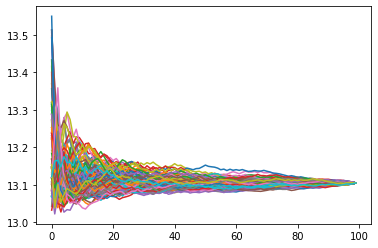

In [71]:
for r in results:
    plt.plot(r)

In [81]:
individual_scores = [evaluate_ensemble(p[np.newaxis, ...], y_test) for p in preds]

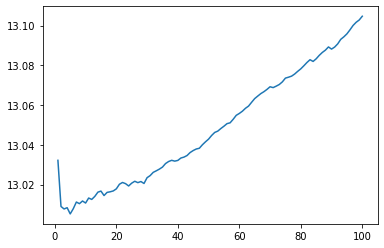

In [86]:
smapes = []
indices = np.argsort(individual_scores)

for i in range(1, 101):
    smapes.append(evaluate_ensemble(preds[indices[:i]], y_test))
    
plt.plot(range(1, 101), smapes)

## Other hundred models

In [10]:
hundred_models = 'inp_18__out_12__loss_mae__bksize_200__bkact_leaky__dir_bi__'

hundred_model_dirs = [str(p / hundred_models) + str(i) + '/best_weights.h5' for i in range(100)]

In [12]:
preds_2 = ensemble_preds(hundred_model_dirs, X_test)


100%|██████████| 100/100 [07:24<00:00,  4.44s/it]


In [13]:
hundred_models = 'inp_18__out_12__loss_mae__bksize_200__bkact_tanh__dir_bi__'

hundred_model_dirs = [str(p / hundred_models) + str(i) + '/best_weights.h5' for i in range(100)]
preds_3 = ensemble_preds(hundred_model_dirs, X_test)


100%|██████████| 100/100 [07:31<00:00,  4.51s/it]


In [14]:
hundred_models = 'inp_18__out_12__loss_mae__bksize_250__bkact_relu__dir_bi__'

hundred_model_dirs = [str(p / hundred_models) + str(i) + '/best_weights.h5' for i in range(100)]
preds_4 = ensemble_preds(hundred_model_dirs, X_test)


100%|██████████| 100/100 [07:33<00:00,  4.53s/it]


In [15]:
hundred_models = 'inp_18__out_12__loss_mae__bksize_250__bkact_leaky__dir_bi__'

hundred_model_dirs = [str(p / hundred_models) + str(i) + '/best_weights.h5' for i in range(100)]
preds_5 = ensemble_preds(hundred_model_dirs, X_test)


100%|██████████| 100/100 [07:34<00:00,  4.55s/it]


In [16]:
hundred_models = 'inp_18__out_12__loss_mae__bksize_250__bkact_tanh__dir_bi__'

hundred_model_dirs = [str(p / hundred_models) + str(i) + '/best_weights.h5' for i in range(100)]
preds_6 = ensemble_preds(hundred_model_dirs, X_test)


100%|██████████| 100/100 [07:30<00:00,  4.51s/it]


In [18]:
results = [run(preds_2) for _ in range(100)]

In [19]:
data = pd.DataFrame({'smape': pd.concat([pd.Series(r) for r in results])})

run = [[i] * 100 for i in range(100)]
data['num_ensembles'] = data.index
data['run'] = [item for sublist in run for item in sublist]

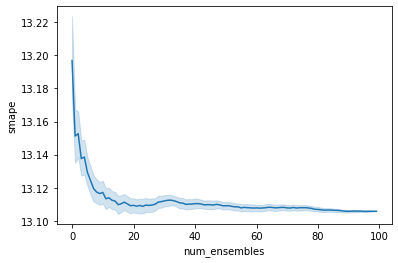

In [20]:
sns.lineplot(x='num_ensembles', y='smape', data=data)

In [26]:
results3 = [run(preds_3) for _ in range(100)]

data = pd.DataFrame({'smape': pd.concat([pd.Series(r) for r in results3])})

runs = [[i] * 100 for i in range(100)]
data['num_ensembles'] = data.index
data['run'] = [item for sublist in runs for item in sublist]

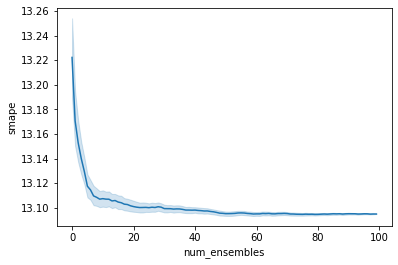

In [27]:
sns.lineplot(x='num_ensembles', y='smape', data=data)